**Purpose?**

> To get an introduction to quant and more generally finance (although finance is just the means here). This notebook will not only serve as code itself, but rather a holistic vessel of my learning; any questions I have during progression will be answered along the way for the purposes of understanding.






**Types of options?**


> Options are categorized as either American or European based on the way they are exercised.

**American vs European options?**


> American options can be exercised any time and consist of most single-stock and ETF options (can be thought of as actual "tangible" stocks). European options are exercised only at expiration. Things like index options, e.g. the S&P 500.


We will first examine European options as naturally, they are mathematically simpler. Let's use a Black Scholes model.


**What is the Black-Scholes pricing model?**


> A mathematical formula used to find the "fair" price for a European option. We need 5 inputs to achieve this:
<br>
$$
\begin{aligned}
C &= S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2) \\
P &= K e^{-rT} N(-d_2) - S_0 e^{-qT} N(-d_1)
\end{aligned}
$$
<br>
1.   S, Stock price today
2.   K, Option's strike price'
3.   T, Option's time to expiry (usually in years)
4.   r, Risk-free interest rate
5.   σ, Volatility
6.   N, This is just the standard normal CDF



**What is $d_1$ and $d_2$?**
<br>
$$
d_1=\frac{\ln\left(\frac{S_0}{K}\right)+\left(r-q+\frac{1}{2}\sigma^2\right)T}{\sigma\sqrt{T}}
$$
<br>
$$
d_2=d_1-\sigma\sqrt{T}
$$
<br>
> These are best thought of as helper quantities for cleaner equations



**Motivation**


> It is generally accepted that S moves randomly, and thus the value is also atleast proportional to some randomness.

$$
\begin{aligned}
dS &= μS(dt) + σS(dW)
\end{aligned}
$$



> Where dW is pure randomness with an average of 0 and follows a *"geometric brownnian motion"*. Brownian motion can be best thought of as a continuous drunkards path; i.e. a random motion (e.g. "noise", erratic movement of tiny particles like pollen), GBD then can be thought of as an extension of this where the "path" is purely positive and tends to grow over time (drift).

**Shortcomings**


> There are many limitations to the model due to the fact that well, its a model lol. With that being said, it's still probably worth looking at to help develop an *intuition* behind pricing or to possibly even extend upon.


*   Volatility is constant: The σ term itself assumes no change. E.g. in pricing say, a 1 month option, its assumed that for every day the same volatility
*  Frictionless market: It is assumed no taxes, transaction costs, etc.
*  Perfect liquidity: buy/sell instantly without affecting market price










In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.stats import norm

In [ ]:
# Formulas for black scholes
def d1_calc(S, K, T, R, sigma):
  return (np.log(S/K) + (R + sigma**2/2)*T) / (sigma * np.sqrt(T))

def d2_calc(S, K, T, R, sigma):
  return d1_calc(S, K, T, R, sigma) - sigma * np.sqrt(T)

def black_scholes_call(S, K, T, R, sigma):
  d1 = d1_calc(S, K, T, R, sigma)
  d2 = d2_calc(S, K, T, R, sigma)
  return S * norm.cdf(d1) - K * np.exp(-R * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, R, sigma):
  d1 = d1_calc(S, K, T, R, sigma)
  d2 = d2_calc(S, K, T, R, sigma)
  return K * np.exp(-R * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


**Monte Carlo Simulations**


> The black scholes equations can give us a solution in closed-form. We can use MC simulations to average off the payoff for a range of possible S values. We can solve for this through the black scholes equation

$$
\begin{aligned}
dS &= μS(dt) + σS(dW)
\end{aligned}
$$
Then,
$$
S_T = S_0 \exp\!\left(\left(r - \frac{1}{2}\sigma^2\right)T + \sigma\sqrt{T}\,Z\right),
\quad Z \sim \mathcal{N}(0,1)
$$


> We can interpret this equation as following a derministic trend (the first term) + a random bit that scales with the normal distribution. We can generate many of these and average them for our approximation.

**Limitations**


> I think the main limitation is computation. We can observe that error is related to sample size by 1/(N^0.5), e.g. for 10x less error, we would need 100x more simulations:
$$
\operatorname{Var}(\hat V)=\operatorname{Var}\!\left(\frac{1}{N}\sum_{i=1}^N X_i\right)
=\frac{1}{N^2}\sum_{i=1}^N \operatorname{Var}(X_i)
=\frac{N\,\operatorname{Var}(X)}{N^2}
=\frac{\operatorname{Var}(X)}{N}
$$

$$
\operatorname{SD}(\hat V)=\sqrt{\operatorname{Var}(\hat V)}
=\sqrt{\frac{\operatorname{Var}(X)}{N}}
=\frac{\sqrt{\operatorname{Var}(X)}}{\sqrt{N}}
$$



In [ ]:
# MC pricer, get call and put prices along with 95% intervals
def mc_call(S, K, T, R, sigma, N=100000, seed=0):
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal(N)
    ST = S * np.exp((R - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0.0)
    disc_payoff = np.exp(-R * T) * payoff
    price = disc_payoff.mean()
    ci95 = 1.96 * disc_payoff.std(ddof=1) / np.sqrt(N)
    return price, (price - ci95, price + ci95)

def mc_put(S, K, T, R, sigma, N=100000, seed=0):
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal(N)
    ST = S * np.exp((R - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(K - ST, 0.0)
    disc_payoff = np.exp(-R * T) * payoff
    price = disc_payoff.mean()
    ci95 = 1.96 * disc_payoff.std(ddof=1) / np.sqrt(N)
    return price, (price - ci95, price + ci95)

In [ ]:
# Function calls
S, K, T, R, sigma = 100, 100, 1.0, 0.05, 0.2

bsC = black_scholes_call(S, K, T, R, sigma)
bsP = black_scholes_put(S, K, T, R, sigma)

mcC, ciC = mc_call(S, K, T, R, sigma, N=100000, seed=1)
mcP, ciP = mc_put(S, K, T, R, sigma, N=100000, seed=1)

print(f"BS Call: {bsC:.2f}")
print(f"MC Call: {mcC:.2f} CI: ({ciC[0]:.2f}, {ciC[1]:.2f})")

print(f"BS Put : {bsP:.2f}")
print(f"MC Put : {mcP:.2f} CI: ({ciP[0]:.2f}, {ciP[1]:.2f})")

BS Call: 10.45
MC Call: 10.36 CI: (10.27, 10.45)
BS Put : 5.57
MC Put : 5.58 CI: (5.53, 5.64)


In [ ]:
# Ok cool, now lets see how values change with different N's
Ns = [5, 10, 50, 200, 500, 1000, 5000, 10000, 100000]
rows = []
for N in Ns:
    t0 = time.perf_counter()
    mcC, ciC = mc_call(S, K, T, R, sigma, N=N, seed=1)
    mcP, ciP = mc_put(S, K, T, R, sigma, N=N, seed=1)
    dt = time.perf_counter() - t0

    rows.append({
        "N": N,
        "MC Call": mcC,
        "CI Call Low": ciC[0],
        "CI Call High": ciC[1],
        "Abs Err Call": abs(mcC - bsC),

        "MC Put": mcP,
        "CI Put Low": ciP[0],
        "CI Put High": ciP[1],
        "Abs Err Put": abs(mcP - bsP),

        "Runtime (s)": dt
    })

df = pd.DataFrame(rows)
df

,N,MC Call,CI Call Low,CI Call High,Abs Err Call,MC Put,CI Put Low,CI Put High,Abs Err Put,Runtime (s)
0,5,12.452356,4.479453,20.425260,2.001773,3.918455,-3.761717,11.598628,1.655071,0.000490
1,10,10.843657,6.296886,15.390429,0.393074,2.667625,-1.268012,6.603262,2.905901,0.000644
2,50,8.377553,4.959405,11.795701,2.073031,4.685163,2.340379,7.029947,0.888363,0.000311
3,200,8.627197,6.842812,10.411583,1.823386,5.503031,4.295747,6.710315,0.070495,0.000338
4,500,9.035459,7.867116,10.203803,1.415124,5.193723,4.477088,5.910357,0.379803,0.000393
5,1000,9.610089,8.735528,10.484650,0.840494,5.864595,5.315759,6.413432,0.291069,0.002036
6,5000,10.258238,9.846478,10.669997,0.192346,5.659135,5.418731,5.899540,0.085609,0.000648
7,10000,10.304293,10.018126,10.590459,0.146291,5.651588,5.481174,5.822003,0.078062,0.002441
8,100000,10.357758,10.266770,10.448745,0.092826,5.584295,5.530770,5.637820,0.010769,0.009123


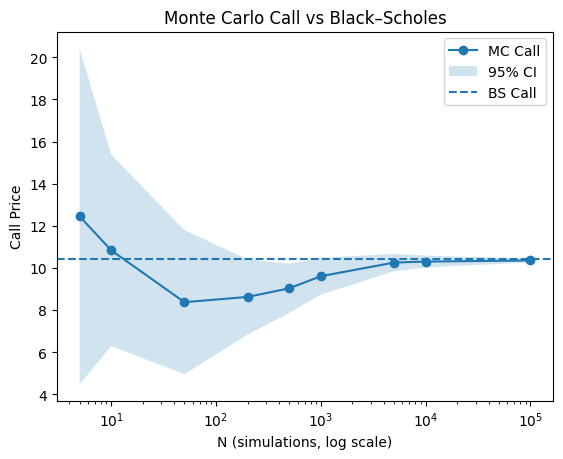

In [ ]:
# MCC vs BSC, we should expect similar results for puts
mcC = df["MC Call"].to_numpy()
ciCL = df["CI Call Low"].to_numpy()
ciCH = df["CI Call High"].to_numpy()

plt.figure()
plt.plot(Ns, mcC, marker="o", linestyle="-", label="MC Call")
plt.fill_between(Ns, ciCL, ciCH, alpha=0.2, label="95% CI")
plt.axhline(bsC, linestyle="--", label="BS Call")

plt.xscale("log")
plt.xlabel("N (simulations, log scale)")
plt.ylabel("Call Price")
plt.title("Monte Carlo Call vs Black–Scholes")
plt.legend()
plt.show()

**Takeaways**


>We can see that due to the law of large numbers, as the number of simulations
N→∞, the Monte Carlo estimate converges to the same option value as the Black–Scholes closed-form price (under the same model assumptions). A key advantage of Monte Carlo is its logical simplicity: simulate price paths consistent with the model, compute the payoff for each path, discount, and average. In practice, this approach is especially useful for contracts where no simple closed-form solution exists (e.g. American options via Least-Squares Monte Carlo). Of course we should still keep in mind the computational costs in all cases.

